In [1]:
!pip install transformers 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 38.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 15.0 MB/s eta 0:00:00


In [2]:
import os
os.environ['KAGGLE_USERNAME'] = "xx"
os.environ['KAGGLE_KEY'] = "xx" # Enter your Kaggle key here

In [3]:
!kaggle datasets download -d adityajn105/flickr8k

 99% 1.02G/1.04G [00:08<00:00, 155MB/s]
100% 1.04G/1.04G [00:08<00:00, 130MB/s]


In [4]:
!unzip -q flickr8k.zip 

In [5]:
!kaggle datasets download -d begum302553/tasviret-flickr8k-turkish

  0% 0.00/946k [00:00<?, ?B/s]
100% 946k/946k [00:00<00:00, 101MB/s]


In [6]:
!unzip -q tasviret-flickr8k-turkish.zip 

In [10]:
from __future__ import print_function, division
import pandas as pd
import torch
import torch.nn as nn
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import torch.nn.functional as F
from tqdm import tqdm
import random
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.utils as vutils
from torchvision.transforms.functional import (
    hflip,
    adjust_brightness,
    adjust_contrast,
    adjust_hue,
    adjust_saturation,
)
import torch.nn.functional as F
import numpy as np
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from datetime import datetime
from torchvision import models
from transformers import AutoTokenizer, AutoModel

In [8]:
data = pd.read_json("tasviret8k_captions.json")

In [9]:
data.head()

,images,dataset
0,"{'split': 'train', 'filename': '2513260012_03d...",flickr8k
1,"{'split': 'train', 'filename': '2903617548_d3e...",flickr8k
2,"{'split': 'train', 'filename': '3338291921_fe7...",flickr8k
3,"{'split': 'train', 'filename': '488416045_1c6d...",flickr8k
4,"{'split': 'train', 'filename': '2644326817_8f4...",flickr8k


In [11]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.image_encoder = models.resnet18(weights = "ResNet18_Weights.DEFAULT")
        self.image_encoder.fc = nn.Identity()
        
        self.image_out = nn.Sequential(
            nn.Linear(512, 256), nn.ReLU(), nn.Linear(256, 256)
        )

        self.text_encoder = AutoModel.from_pretrained("dbmdz/distilbert-base-turkish-cased")
        self.target_token_idx = 0


        self.text_out = nn.Sequential(
            nn.Linear(768, 256), nn.ReLU(), nn.Linear(256, 256)
        )
      

    def forward(self, image, text, mask):

        image_vec = self.image_encoder(image)
        #print("resnet out",image_vec.shape)
        image_vec = self.image_out(image_vec.view(-1,512))
        #print("image vec",image_vec.shape)
        #print("text",text.shape)
        #print("mask",mask.shape)
        text_out = self.text_encoder(text, mask)
        last_hidden_states = text_out.last_hidden_state
        #print("last_hidden_states 1",last_hidden_states.shape)
        last_hidden_states = last_hidden_states[:,self.target_token_idx,:]
        #print("last_hidden_states 2",last_hidden_states.shape)
        text_vec = self.text_out(last_hidden_states.view(-1,768))


        return image_vec, text_vec

In [13]:
model = Net()

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Some weights of the model checkpoint at dbmdz/distilbert-base-turkish-cased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [16]:
model.load_state_dict(torch.load("clip_model.pt", map_location=torch.device('cpu')))
model.eval()

Net(
  (image_encoder): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_r

In [30]:
soft = nn.Softmax(dim=1)
transform=transforms.Compose(
        [
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
],
)

In [32]:
tokenizer = AutoTokenizer.from_pretrained("dbmdz/distilbert-base-turkish-cased")
def load_image(id):
  file_name = data[7000:]["images"].values[id]["filename"]
  print(data[7000:]["images"].values[id]["filename"])
  print(data[7000:]["images"].values[id]["sentences"])
  img = Image.open("./Images/{}".format(file_name))
  plt.imshow(img)
  plt.show()
  return img
  
def predict(img,text_vec):
  input = transform(img).unsqueeze(0)
  token_list = tokenizer(text_vec,padding = True)

  text = torch.Tensor(token_list["input_ids"]).long()
  mask = torch.Tensor(token_list["attention_mask"]).long()


  image_vec, text_vec = model(input, text , mask) 
  print(soft(torch.matmul(image_vec,text_vec.T)))

3462454965_a481809cea.jpg
[{'sentid': 14234, 'imgid': 7100, 'raw': 'Üç köpek kameraya doğru koşuyorlar.', 'tokens': ['Üç', 'köpek', 'kameraya', 'doğru', 'koşuyorlar']}, {'sentid': 14235, 'imgid': 7100, 'raw': 'Bir köşesinde sulak bir kısmın bulunduğu bir çayırda koşan üç köpek.', 'tokens': ['Bir', 'köşesinde', 'sulak', 'bir', 'kısmın', 'bulunduğu', 'bir', 'çayırda', 'koşan', 'üç', 'köpek']}]


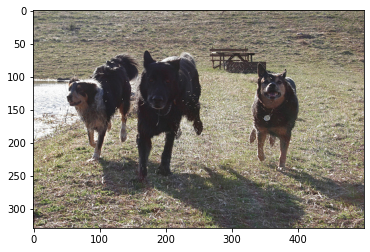

In [33]:
img = load_image(100)

In [34]:
text_vec = ["Koşan iki köpek.","Koşan üç köpek."]
predict(img,text_vec)

tensor([[0.4305, 0.5695]], grad_fn=<SoftmaxBackward0>)


1322323208_c7ecb742c6.jpg
[{'sentid': 14834, 'imgid': 7400, 'raw': 'Gün batımında sahilde oyun oynayan iki erkek çocuğu.', 'tokens': ['Gün', 'batımında', 'sahilde', 'oyun', 'oynayan', 'iki', 'erkek', 'çocuğu']}, {'sentid': 14835, 'imgid': 7400, 'raw': 'İki çocuk güneş ufuktayken bir sahilde birlikte oyun oynuyorlar.', 'tokens': ['İki', 'çocuk', 'güneş', 'ufuktayken', 'bir', 'sahilde', 'birlikte', 'oyun', 'oynuyorlar']}]


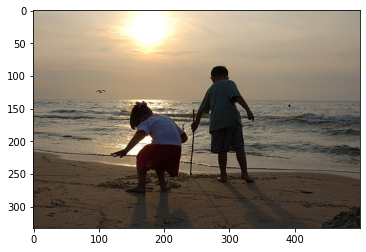

In [38]:
img = load_image(400)

In [40]:
text_vec = ["Gün batımında kumla oynayan iki çocuk.","Gece kumla oynayan iki çocuk.","Kumla oynayan üç çocuk."]
predict(img,text_vec)

tensor([[0.6866, 0.2525, 0.0609]], grad_fn=<SoftmaxBackward0>)


1446053356_a924b4893f.jpg
[{'sentid': 15034, 'imgid': 7500, 'raw': 'İki kız çocuğu futbol oynuyor.', 'tokens': ['İki', 'kız', 'çocuğu', 'futbol', 'oynuyor']}, {'sentid': 15035, 'imgid': 7500, 'raw': 'Çimlerde antreman yapan genç kızlar.', 'tokens': ['Çimlerde', 'antreman', 'yapan', 'genç', 'kızlar']}]


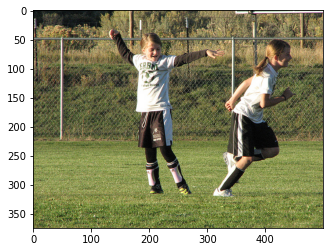

In [64]:
img = load_image(500)

In [65]:
text_vec = ["İki oğlan çocuğu futbol oynuyor.","İki kız çocuğu futbol oynuyor."]
predict(img,text_vec)

tensor([[0.4366, 0.5634]], grad_fn=<SoftmaxBackward0>)


3019842612_8501c1791e.jpg
[{'sentid': 15235, 'imgid': 7600, 'raw': 'Mavi tişörtlü bir çocuk kaykay yapıyor.', 'tokens': ['Mavi', 'tişörtlü', 'bir', 'çocuk', 'kaykay', 'yapıyor']}, {'sentid': 15236, 'imgid': 7600, 'raw': 'Kaykaylı bir adam sokakta kayarken.', 'tokens': ['Kaykaylı', 'bir', 'adam', 'sokakta', 'kayarken']}]


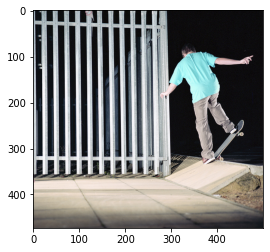

In [45]:
img = load_image(600)

In [47]:
text_vec = ["Mavi tişörtlü bir kaykaycı.","Sarı tişörtlü bir kaykaycı.","Kırmızı tişörtlü bir kaykaycı."]
predict(img,text_vec)

tensor([[0.3440, 0.2990, 0.3570]], grad_fn=<SoftmaxBackward0>)


In [48]:
text_vec = ["Mavi tişörtlü bir çocuk kaykay yapıyor.","Sarı tişörtlü bir çocuk kaykay yapıyor.","Kırmızı tişörtlü bir çocuk kaykay yapıyor."]
predict(img,text_vec)

tensor([[0.3368, 0.3042, 0.3590]], grad_fn=<SoftmaxBackward0>)


219301555_17883a51bd.jpg
[{'sentid': 15937, 'imgid': 7950, 'raw': 'Şelaleden akan su içinde dolaşan kız.', 'tokens': ['Şelaleden', 'akan', 'su', 'içinde', 'dolaşan', 'kız']}, {'sentid': 15938, 'imgid': 7950, 'raw': 'Bir kız şelanin önünde sularda yürüyor.', 'tokens': ['Bir', 'kız', 'şelanin', 'önünde', 'sularda', 'yürüyor']}]


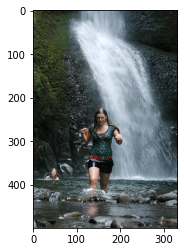

In [53]:
img = load_image(950)

In [55]:
text_vec = ["Şelaleden su akıyor.","Şelaleden ateş akıyor."]
predict(img,text_vec)

tensor([[0.7723, 0.2277]], grad_fn=<SoftmaxBackward0>)


2256133102_e2c8314ecb.jpg
[{'sentid': 14236, 'imgid': 7101, 'raw': 'Faleze tırmanan dağcı.', 'tokens': ['Faleze', 'tırmanan', 'dağcı']}, {'sentid': 14237, 'imgid': 7101, 'raw': 'İp ile kayalıklardan aşağıya inen sporcu.', 'tokens': ['İp', 'ile', 'kayalıklardan', 'aşağıya', 'inen', 'sporcu']}]


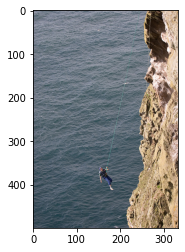

In [57]:
img = load_image(101)

In [59]:
text_vec = ["Tırmanış yapan bir dağcı.","Denize iple sarkan bir yüzücü."]
predict(img,text_vec)

tensor([[0.9342, 0.0658]], grad_fn=<SoftmaxBackward0>)


3186412658_2ab2ebd397.jpg
[{'sentid': 14238, 'imgid': 7102, 'raw': 'Bir kadın ragbi takımı oyuncuları havadaki ragbi topunu yakalamaya çalışıyor.', 'tokens': ['Bir', 'kadın', 'ragbi', 'takımı', 'oyuncuları', 'havadaki', 'ragbi', 'topunu', 'yakalamaya', 'çalışıyor']}, {'sentid': 14239, 'imgid': 7102, 'raw': 'Havaya sıçrayarak topu kapmaya çalışan kadın ragbi oyuncuları.', 'tokens': ['Havaya', 'sıçrayarak', 'topu', 'kapmaya', 'çalışan', 'kadın', 'ragbi', 'oyuncuları']}]


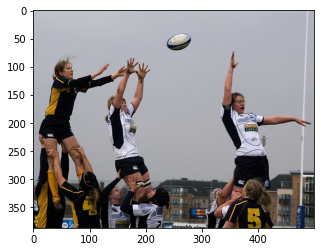

In [60]:
img = load_image(102)

In [62]:
text_vec = ["Kadın voleybol takımı.","Kadın ragbi takımı."]
predict(img,text_vec)

tensor([[0.9337, 0.0663]], grad_fn=<SoftmaxBackward0>)


In [63]:
text_vec = ["Kadın voleybol takımı.","Bir kadın ragbi takımı oyuncuları havadaki ragbi topunu yakalamaya çalışıyor."]
predict(img,text_vec)

tensor([[0.9422, 0.0578]], grad_fn=<SoftmaxBackward0>)
